# CIGALE Luminosity Functions

### Import and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(6, 14, 0.25) # luminosity bin edges
# lum_bin_edges = np.arange(6, 14, 0.5) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

### Load Data

In [2]:
# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN4.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN4.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN4.csv', index_col='Seq')

# All CIGALE sources
oCDFS = pd.read_csv('../DATA/Ollie Data/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/Ollie Data/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/Ollie Data/UDS/results.txt', delim_whitespace=True, index_col='id')

### Mask & Combine Data

Must be done from individual fields, otherwise the data masks won't align. This is because Ollie dropped failed ID's instead of assigning a bad value.

In [3]:
def mask_data(zfourge, cigale, survey_name):
    # Use Mask
    use_mask = zfourge['Use'] == 1
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Use=1: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Use=1: {len(cigale)}')

    # LIR Mask
    lir_mask = zfourge['LIR'] > 0 
    zfourge = zfourge.loc[lir_mask]
    cigale = cigale.loc[lir_mask]
    # print(f'Number of ZFOURGE {survey_name} sources LIR>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources LIR>0: {len(cigale)}')

    # F24 Mask
    F24_mask = zfourge['F24'] > 0 
    zfourge = zfourge.loc[F24_mask]
    cigale = cigale.loc[F24_mask]
    # print(f'Number of ZFOURGE {survey_name} sources F24>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources F24>0: {len(cigale)}')

    # Redshift Mask
    red_mask = (zfourge['zpk'] >= redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    # print(f'Number of ZFOURGE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(cigale)}')

    # AGN Mask
    agn_mask = (zfourge['irAGN'] == 1) | (zfourge['radAGN'] == 1) | (zfourge['xAGN'] == 1) 
    zfourge = zfourge.loc[~agn_mask]
    cigale = cigale.loc[~agn_mask]
    # print(f'Number of ZFOURGE {survey_name} sources AGN=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources AGN=0: {len(cigale)}')
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Nan=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Nan=0: {len(cigale)}')
    
    # Redshift Mask
    z_mask = cigale['bayes.universe.redshift'] > 0
    zfourge = zfourge.loc[z_mask]
    cigale = cigale.loc[z_mask]
    # print(f'Number of ZFOURGE {survey_name} sources z>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources z>0: {len(cigale)}')
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    print(f'Number of common sources: {len(zfourge)}')
    print('\n')
    return zfourge, cigale

print(f'Total number of sources CIGALE: {len(oCDFS) + len(oCOSMOS) + len(oUDS)} \n')
CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS, 'CDFS')
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS, 'COSMOS')
UDS_m, oUDS_m = mask_data(UDS, oUDS, 'UDS')

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Number of ZFOURGE sources: {len(df)}')
print(f'Number of CIGALE sources: {len(odf)}')

Total number of sources CIGALE: 73758 

Number of CIGALE CDFS sources Use=1: 13299
Number of CIGALE CDFS sources LIR>0: 8486
Number of CIGALE CDFS sources F24>0: 8486
Number of CIGALE CDFS sources 0.0 <= z <= 6.0: 8469
Number of CIGALE CDFS sources AGN=0: 8193
Number of CIGALE CDFS sources Nan=0: 8187
Number of CIGALE CDFS sources z>0: 8187
Number of common sources: 8187


Number of CIGALE COSMOS sources Use=1: 12901
Number of CIGALE COSMOS sources LIR>0: 7954
Number of CIGALE COSMOS sources F24>0: 7954
Number of CIGALE COSMOS sources 0.0 <= z <= 6.0: 7947
Number of CIGALE COSMOS sources AGN=0: 7815
Number of CIGALE COSMOS sources Nan=0: 7815
Number of CIGALE COSMOS sources z>0: 7814
Number of common sources: 7814


Number of CIGALE UDS sources Use=1: 11447
Number of CIGALE UDS sources LIR>0: 6557
Number of CIGALE UDS sources F24>0: 6557
Number of CIGALE UDS sources 0.0 <= z <= 6.0: 6551
Number of CIGALE UDS sources AGN=0: 6436
Number of CIGALE UDS sources Nan=0: 6436
Number of CIGALE 

C:\Users\danie\AppData\Local\Temp\ipykernel_20368\2159671330.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


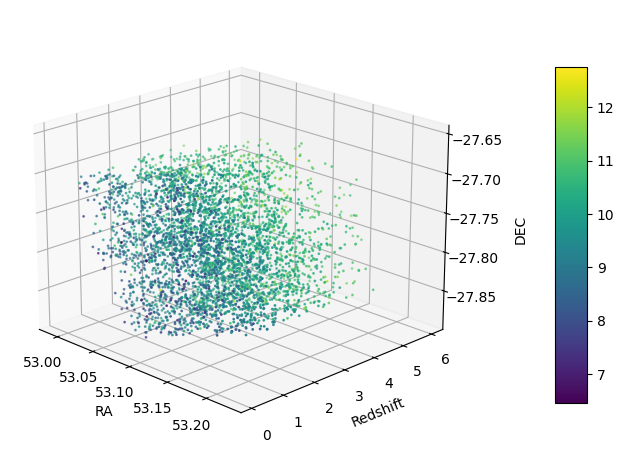

In [4]:
# # %matplotlib widget

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Low AGN Mask
# agn_frac = oCDFS_m['bayes.agn.fracAGN'].values
# mask_low_agn = agn_frac > 0.1

# CDFS_m = CDFS_m.loc[mask_low_agn]
# oCDFS_m = oCDFS_m.loc[mask_low_agn]

# ra = CDFS_m['RAJ2000'] # Right Ascension
# dec = CDFS_m['DEJ2000'] # Declination
# lum = np.log10(oCDFS_m['bayes.agn.luminosity'].values/(3.83*10**26)) # Watts
# z = CDFS_m['zpk'] # Redshift

# pcm = ax.scatter(ra, z, dec, s=1, cmap='viridis', c=lum)
# ax.set_xlabel('RA')
# ax.set_ylabel('Redshift')
# ax.set_zlabel('DEC', rotation=90, labelpad=10)
# ax.set_zlabel('DEC')
# ax.view_init(azim=-45, elev=20)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# fig.colorbar(pcm, cax=cbar_ax)
# plt.tight_layout()
# plt.savefig('CDFS.png')
# plt.show()

### Sanity Check

In [ ]:
zf_lum = df['LIR'] # Solar Luminosity
cg_lum = (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])/(3.83*10**26) # Solar Luminosity

x = np.linspace(5, 15, 100)

plt.scatter(np.log10(zf_lum), np.log10(cg_lum), s=1)
plt.plot(x, x, linestyle='--', color='red')
plt.title('Luminosity Comparison')
plt.ylabel('CIGALE Luminosity (log10 L$_\odot$)')
plt.xlabel('ZFOURGE Luminosity (log10 L$_\odot$)')
plt.grid()
plt.xlim(5, 15)
plt.ylim(5, 15)
plt.show()

zf_z = df['zpk']
cg_z = odf['bayes.universe.redshift']
plt.scatter(zf_z, cg_z, s=1)
plt.plot([redshift_bins[0][0], redshift_bins[-1][1]], [redshift_bins[0][0], redshift_bins[-1][1]], color='red', linestyle='--')
plt.title('Redshift Comparison')
plt.ylabel('CIGALE Redshift')
plt.xlabel('ZFOURGE Redshift')
plt.ylim(redshift_bins[0][0], redshift_bins[-1][1])
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.grid()
plt.show()

### Total Luminosity

In [ ]:
luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values + odf['bayes.agn.luminosity'].values # Watts

### Stellar Luminosity

In [ ]:
# Low SFR Mask
# sf_frac = 1 - odf['bayes.agn.fracAGN'].values
# mask_low_sf = sf_frac > 0.1
# df = df.loc[mask_low_sf]
# odf = odf.loc[mask_low_sf]
# print(f'Number of sources SF>0.1: {len(odf)}')

# plt.hist(sf_frac, bins=np.linspace(0, 1, 21), histtype='step')
# plt.xticks(np.linspace(0, 1, 11))
# plt.ylabel('Number of sources')
# plt.xlabel('SF Fraction')
# plt.show()

luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values # Watts
print(f'Number of sources AGN>0.1: {len(odf)}')


### AGN Luminosity

In [ ]:
# Low AGN Mask
agn_frac = odf['bayes.agn.fracAGN'].values
mask_low_agn = agn_frac > 0.1
df = df.loc[mask_low_agn]
odf = odf.loc[mask_low_agn]
print(f'Number of sources AGN>0.1: {len(odf)}')

plt.hist(agn_frac, bins=np.linspace(0, 1, 21), histtype='step')
plt.xticks(np.linspace(0, 1, 11))
plt.ylabel('Number of sources')
plt.xlabel('AGN Fraction')
plt.show()

luminosity = odf['bayes.agn.luminosity'].values # Watts

### Luminosity Distribution & Bolometric Flux Limit

In [ ]:
z = odf['bayes.universe.redshift'].values.copy() # redshift

# Plot Colours
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))

# Luminsity distance of galaxies
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

# Bolometric Flux completeness limits
F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2
Fbol_lim = np.percentile(F_bol, 100-F_comp) # % of the data above perc
mask_fbol = F_bol > Fbol_lim
plt.scatter(z, np.log10(F_bol), s=1, color='grey', alpha=0.3)
plt.scatter(z[mask_fbol], np.log10(F_bol[mask_fbol]), s=1)
plt.axhline(np.log10(Fbol_lim), color='black', linestyle='--')
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log(Flux) [$W/m^2$]')
plt.xlabel('z')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.show()

# Luminsity-redshift distribution
plt.scatter(z, np.log10(luminosity/(3.83*10**26)), s=1, color='grey')
plt.scatter(z[mask_fbol], np.log10(luminosity[mask_fbol]/(3.83*10**26)), s=1)
plt.ylabel('log($L_{IR}$) [$L_\odot$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.ylim(7, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.tick_params(axis='both', labelsize=20)
plt.show()

print(f'Number of galaxies: {len(z[mask_fbol])}')
print(f'Bolometric Flux Completeness: {Fbol_lim:.2e} W/m^2')

In [ ]:
zf_lum = df['LIR'] # Solar Luminosity
cg_lum = (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])/(3.83*10**26) # Solar Luminosity
agn_frac = (odf['bayes.agn.luminosity']) / (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])

print(len(zf_lum), len(cg_lum), len(agn_frac))

fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True, layout='constrained')
# ax[0].scatter(np.log10(zf_lum), np.log10(cg_lum), s=1, color='grey', alpha=0.3, label='Removed')
# ax[1].scatter(np.log10(zf_lum), np.log10(cg_lum), s=1, color='grey', alpha=0.3, label='Removed')
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))
for (z_start, z_end), c in zip(redshift_bins, colors):
    mask = (df['zpk'] >= z_start) & (df['zpk'] < z_end)
    # ax[0].scatter(np.log10(zf_lum[mask_fbol][mask]), np.log10(cg_lum[mask_fbol][mask]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
    ax[0].scatter(np.log10(zf_lum[mask]), np.log10(cg_lum[mask]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
# map = ax[1].scatter(np.log10(zf_lum[mask_fbol]), np.log10(cg_lum[mask_fbol]), s=1, cmap='viridis', c=agn_frac[mask_fbol], vmin=0.0, vmax=1)
map = ax[1].scatter(np.log10(zf_lum), np.log10(cg_lum), s=1, cmap='plasma', c=agn_frac, vmin=0.0, vmax=1)
x = np.linspace(5, 15, 100)
ax[0].plot(x, x, linestyle='--', color='red')
ax[1].plot(x, x, linestyle='--', color='red')
fig.supylabel('CIGALE Luminosity [log L$_\odot$]', fontsize=20)
fig.supxlabel('ZFOURGE Luminosity [log L$_\odot$]', fontsize=20)
ax[0].set_xlim(7, 14)
ax[0].set_ylim(7, 14)
ax[0].grid()
ax[1].grid()
ax[0].tick_params(axis='both', labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)
ax[0].set_xticks([8,10,12,14])
ax[0].set_yticks([8,10,12,14])
ax[0].legend(bbox_to_anchor=(1,0.9), fontsize=12, markerscale=5)
cbar = fig.colorbar(map, ax=ax[1], orientation='vertical', pad=-0.25)
cbar.set_label('AGN Fraction', fontsize=20)
cbar.ax.tick_params(labelsize=12)
plt.subplots_adjust(hspace=0)
# plt.savefig('LIR vs LIR.png', dpi=300)
plt.show()

plt.hist(np.log10(zf_lum), bins=lum_bin_edges, alpha=0.5, label='ZFOURGE', histtype='step')
plt.hist(np.log10(cg_lum), bins=lum_bin_edges, alpha=0.5, label='CIGALE', histtype='step')
plt.ylabel('Number of sources')
plt.xlabel('log $L_\odot$')
plt.legend()
plt.show()

plt.hist(agn_frac, bins=np.linspace(0, 1, 21), histtype='step')
plt.xticks(np.linspace(0, 1, 11))
plt.ylabel('Number of sources')
plt.xlabel('AGN Fraction')
plt.show()

for z_start, z_end in redshift_bins:
    mask = (df['zpk'] >= z_start) & (df['zpk'] < z_end)
    mean_agn_frac = np.mean(agn_frac[mask])
    print(f'{z_start} <= z < {z_end}: average agn frac = {mean_agn_frac}')

n_agn_over_50 = np.sum(agn_frac > 0.5)
print(f'Number of sources with AGN fraction > 0.5: {n_agn_over_50}')

agn_over_10 = np.sum(agn_frac > 0.1)
print(f'Number of sources with AGN fraction > 0.1: {agn_over_10}')

### Calculate Maximum Volume

In [ ]:
def lum_lim(z, f_lim):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # W

all_data = []
zmaxs = []
L_lims = []

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    
    # Source lumiosity must be greater than the minimum luminosity (from luminosity distance)
    l_lim = lum_lim(z_end, Fbol_lim)
    mask_l = luminosity > l_lim
    
    # Luminosity of galaxies in each redshift bin
    lum_bin = np.log10(luminosity[mask_z & mask_fbol & mask_l]/(3.83*10**26))
    
    # Minimum and maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmax = cosmo.comoving_distance(z_end).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask_z & mask_fbol & mask_l] / (4*np.pi*Fbol_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
        
    # Limit the maximum galaxy distance to the end of the redshift bin
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Find the maximum redshift of each source
    zmax_bin = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    
    # Data
    all_data.append([vol, lum_bin])
    zmaxs.append(zmax_bin)
    L_lims.append(l_lim)
    
    # Plot
    plt.scatter(zmax_bin, lum_bin, s=5, label=f'{z_start} $\leq$ z < {z_end}')
    plt.scatter(z_end, np.log10(l_lim/(3.83*10**26)), s=5, color='black')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(L$_{bol}$) [L$_\odot$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+0.1)
plt.show()

for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Volume')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

print(f'Number of sources: {np.sum([len(v) for v, m in all_data])}')

for (z_start, z_end), (v, m) in zip(redshift_bins, all_data):
    FIRGs = m < 11 # faint infrared galaxies
    LIRGs = (m >= 11) & (m < 12) # luminous infrared galaxies
    ULIRGs = m >= 12 # ultraluminous infrared galaxies
    total_lum = np.sum(10**m)
    print(f'{z_start} <= z < {z_end} - Num Contribution - FIRGs: {np.round((sum(FIRGs)/len(m))*100,2)}% - LIRGs: {np.round((sum(LIRGs)/len(m))*100,2)}% - ULIRGs: {np.round((sum(ULIRGs)/len(m))*100,2)}%')
    print(f'{z_start} <= z < {z_end} - Lum Contribution - FIRGs: {np.round((np.sum(10**m[FIRGs])/total_lum)*100,2)}% - LIRGs: {np.round((np.sum(10**m[LIRGs])/total_lum)*100,2)}% - ULIRGs: {np.round((np.sum(10**m[ULIRGs])/total_lum)*100,2)}%')
    print('\n')

### Counts Histograms

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
bin_edges = []
for ax, (z_start, z_end), (vol, lum), min_l in zip(axes.flatten(), redshift_bins, all_data, L_lims):
    mask_z = (z > z_start) & (z <= z_end)
    mask_l = luminosity > min_l
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append([])
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

### Luminosity Function

In [ ]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    try:
        delta_log_l = np.diff(bin)[0]
    except IndexError:
        lum_centers.append([])
        phi.append([])
        phi_e.append([])
        continue
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        # phi_val = len(vol_lum_bin) / vol_lum_bin[0]
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), L_lims):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.legend()
    
for (z_start, z_end), lum_centers_z, phi_z, phi_e_z in zip(redshift_bins, lum_centers, phi, phi_e):
    if len(lum_centers_z) == 0:
        continue
    print(f'{z_start} <= z < {z_end}')
    print(lum_centers_z)
    print(np.round(np.log10(phi_z),2))
    print(np.round(np.array(phi_e_z) / (np.array(phi_z) * np.log(10)),2))
    print('\n')
    
""" Thorne """
T_L_028 = [5.10e+43, 1.82e+44, 5.87e+44, 1.89e+45]
T_L_045 = [5.33e+43, 1.873e+44, 5.92e+44, 1.68e+45, 5.33e+45]
T_L_056 = [1.75e+44, 6.22e+44, 1.98e+45, 6.33e+45]
T_L_082 = [1.87e+44, 5.33e+44, 1.87e+45, 5.33e+45, 1.87e+46, 5.33e+46]
T_L_10 = [5.03e+44, 1.78e+45, 5.12e+45, 1.63e+46]
T_L_12 = [5.92e+44, 1.87e+45, 5.92e+45, 1.87e+46, 5.92e+46]
T_L_175 = [1.60e+45, 5.69e+45, 1.81e+46, 5.21e+46]
T_L_220 = [1.78e+45, 5.69e+45, 1.81e+46, 5.79e+46, 1.85e+47]
T_L = [T_L_028, T_L_045, T_L_056, T_L_082, T_L_10, T_L_12, T_L_175, T_L_220]
    
T_P_028 = [0.00041, 0.00013, 0.000068, 0.000054]
T_P_045 = [0.0010, 0.00026, 0.00010, 0.000043, 0.000011]
T_P_056 = [0.00033, 0.000085, 0.000034, 0.0000036]
T_P_082 = [0.00033, 0.000085, 0.000022, 0.0000089, 0.0000056, 0.0000014]
T_P_10 = [0.00012, 0.000063, 0.000025, 0.0000031]
T_P_12 = [0.000079, 0.000039, 0.000015, 0.0000031, 0.0000012]
T_P_175 = [0.000027, 0.000014, 0.0000056, 0.0000028]
T_P_220 = [0.000027, 0.000014, 0.0000071, 0.0000022, 7.39e-7]
T_P = [T_P_028, T_P_045, T_P_056, T_P_082, T_P_10, T_P_12, T_P_175, T_P_220]

for i, (ax, lumt, phit) in enumerate(zip(axes.flatten(), T_L, T_P)):
    ax.scatter(np.log10(np.array(lumt)*(2.612*10**-34)), np.log10(phit), color='red', marker='v', label='Thorne+22' if i == 1 else "")
    
""" Symeonidis """
S_L_02 = [10.17, 10.53, 10.86, 11.22, 11.57]
S_L_04 = [10.17, 10.53, 10.86, 11.22, 11.55, 11.91, 12.26, 12.62]
S_L_06 = [10.17, 10.51, 10.87, 11.20, 11.56, 11.92, 12.26, 12.59]
S_L_08 = [10.17, 10.51, 10.86, 11.22, 11.57, 11.88, 12.24, 12.60, 12.93]
S_L_10 = [10.20, 10.53, 10.91, 11.22, 11.57, 11.91, 12.26, 12.60, 12.95]
S_L_12 = [10.15, 10.51, 10.85, 11.18, 11.56, 11.92, 12.26, 12.59, 12.97, 13.31]
S_L_15 = [10.17, 10.53, 10.85, 11.23, 11.58, 11.90, 12.26, 12.61, 12.95, 13.31]
S_L_20 = [10.19, 10.52, 10.86, 11.23, 11.58, 11.89, 12.25, 12.60, 12.91, 13.26, 13.59]
S_L_25 = [10.15, 10.53, 10.85, 11.20, 11.56, 11.92, 12.23, 12.59, 12.95, 13.29]
S_L = [S_L_02, S_L_04, S_L_06, S_L_08, S_L_10, S_L_12, S_L_15, S_L_20, S_L_25]

S_P_02 = [-4.09, -4.56, -5.04, -5.40, -5.59]
S_P_04 = [-4.13, -4.31, -4.60, -4.93, -5.48, -5.84, -6.24, -6.43]
S_P_06 = [-3.91, -4.16, -4.42, -4.67, -5.15, -5.55, -6.13, -6.86]
S_P_08 = [-3.72, -3.87, -4.09, -4.49, -4.89, -5.33, -5.70, -6.06, -6.94]
S_P_10 = [-3.80, -3.94, -4.09, -4.24, -4.53, -5.00, -5.40, -5.84, -6.72]
S_P_12 = [-3.83, -3.94, -4.02, -4.20, -4.53, -4.86, -5.48, -6.02, -6.21, -6.90]
S_P_15 = [-3.84, -3.99, -4.06, -4.13, -4.35, -4.68, -5.23, -5.75, -6.48, -6.81]
S_P_20 = [-3.91, -4.06, -4.13, -4.24, -4.39, -4.65, -5.05, -5.60, -6.19, -6.74, -7.22]
S_P_25 = [-4.06, -4.02, -4.10, -4.28, -4.39, -4.61, -5.01, -5.53, -6.08, -6.66]
S_P = [S_P_02, S_P_04, S_P_06, S_P_08, S_P_10, S_P_12, S_P_15, S_P_20, S_P_25]

for i, (ax, lumt, phit) in enumerate(zip(axes.flatten(), S_L, S_P)):
    ax.scatter(lumt, phit, color='red', marker='x', label='Symeonidis+21' if i == 1 else "")
    
""" ZFOURGE Star Forming """
ZF_SF = np.load('fits/ZFOURGE_SF.npz', allow_pickle=True)
for i, (ax, l, p, e, (z_start, z_end)) in enumerate(zip(axes.flatten(), ZF_SF['x'], ZF_SF['y'], ZF_SF['e'], ZF_SF['z'])):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(l, np.log10(p), yerr=yerr, ls='none', marker='^', capsize=4, label='ZF SF' if i == 0 else '', color='blue')

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)


### Schechter Fit

In [ ]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        schecter_params.append(params)
        schecter_errors.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue

    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Alpha = 1.3')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *(params+perr))),
        np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)
    
for i, (ax, lumt, phit) in enumerate(zip(axes.flatten(), T_L, T_P)):
    ax.scatter(np.log10(np.array(lumt)*(2.612*10**-34)), np.log10(phit), color='maroon', marker='v', label='Thorne+22' if i == 1 else "")

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

In [ ]:
from itertools import zip_longest

def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
sigmas = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] # SF
# sigmas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # AGN
# sigmas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8, 0.7, 0.6] # AGN
# sigmas = [1.0, 0.7, 0.7, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8, 0.7, 0.6] # AGN

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
# for (z_start, z_end), lum, p, e, ax, sigma in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), sigmas):
for (z_start, z_end), lumm, pp, e, ax, sigma, lumt, phit in zip_longest(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), sigmas, T_L, T_P):
    
    if phit != None:
        p = pp.copy() + phit
        lum = lumm.copy() + np.log10(np.array(lumt)*(2.612*10**-34)).tolist()
    else:
        p = pp.copy()
        lum = lumm.copy()
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*1.5, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        saunder_params.append(params)
        saunder_error.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}.')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[1]) / (params[1] * np.log(10)),2)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = {sigma}')
    print('\n')
    
    p = pp.copy()
    lum = np.power(10, lumm.copy())
    
    # Plot the data
    long_lum = np.logspace(7, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color='blue')
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *(params+perr), sigma)), 
        np.log10(saunders_luminosity(long_lum, *np.abs(params-perr), sigma)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(7, 14.5)
    
for i, (ax, lumt, phit) in enumerate(zip(axes.flatten(), T_L, T_P)):
    ax.scatter(np.log10(np.array(lumt)*(2.612*10**-34)), np.log10(phit), color='maroon', marker='v', label='Thorne+22' if i == 1 else "")

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter & Saunders

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for ax, params, perr in zip(axes.flatten(), schecter_params, schecter_errors):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')

# Saunders Function
for ax, params, perr, sigma in zip(axes.flatten(), saunder_params, saunder_error, sigmas):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(saunders_luminosity(long_lum, *p_down, sigma)),
        np.log10(saunders_luminosity(long_lum, *p_up, sigma)),
        color='blue', alpha=0.2, label='Fit Error')

# Luminosity Function
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))        
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try: 
        ax[0].errorbar(z_center, np.log10(p[0]), yerr=(e[0] / (p[0]* np.log(10))), fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, np.log10(p[1]), yerr=(e[1] / (p[1]* np.log(10))), fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, np.log10(p[0]), yerr=(e[0] / (p[0]* np.log(10))), fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, np.log10(p[1]), yerr=(e[1] / (p[1]* np.log(10))), fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
test_lums = np.unique(np.hstack(np.array(lum_centers, dtype=object)))[::2]
print(test_lums)
redshift_centers = np.mean(redshift_bins, axis=1)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(test_lums)))

class_phi = []
for l in test_lums:
    lum_phi = []
    for lcs, p, zc in zip(lum_centers, phi, redshift_centers):
        if l in lcs:
            lum_phi.append((zc, p[lcs.index(l)]))
    class_phi.append(lum_phi)

for cp, col, tl in zip(class_phi, colors, test_lums):
    zx = np.array(cp)[:,0]
    py = np.array(cp)[:,1]
    plt.plot(zx, py, linestyle='-', marker='o', color=col, label=tl)
    
plt.yscale('log')
plt.legend()
plt.show()

### Class Evolution

In [ ]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_classes = np.arange(8, 13.5, 0.5)
# luminosity_classes = np.arange(8, 12.5, 0.5)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(7, 5))

def custom_log_formatter(val, pos):
    # Convert the logarithmic value to an exponent
    exponent = int(np.log10(val))
    return f'${exponent}$'

class_phi = []
for lum in luminosity_classes:
    lum_phi = []
    # for params, perr, sigma in zip(saunder_params, saunder_error, sigmas):
    for params, perr in zip(schecter_params, schecter_errors):
        if len(params) == 0:
            lum_phi.append([np.nan, np.nan, np.nan])
        #     continue
        # phis = saunders_luminosity(10**lum, *params, sigma)
        # phi_up = saunders_luminosity(10**lum, *(params+perr), sigma)
        # phi_down = saunders_luminosity(10**lum, *np.abs(params-perr), sigma)
        phis = schechter_luminosity(10**lum, *params)
        phi_up = schechter_luminosity(10**lum, *(params+perr))
        phi_down = schechter_luminosity(10**lum, *(params-perr))
        lum_phi.append([phis, phi_up-phis, phis-phi_down])
    class_phi.append(lum_phi)

for lum, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    phis = class_lum[:,0]
    phi_up = class_lum[:,1]
    phi_down = class_lum[:,2]
    plt.errorbar(redshift_centers, phis, yerr=[np.abs(phi_down), phi_up], ls='--', capsize=4, marker='*', label=f'{lum}', color=c)
    
plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.xticks([0,1,2,3,4,5])
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.ylim(10**-8, 10**-1)
# plt.ylim(10**-21, 10**-1)
plt.show()

In [ ]:
# lower_bound = 10**8
# upper_bound = 10**14

full_lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
full_lower_bounds[0] = 0
full_upper_bounds = full_lower_bounds[1:] + [np.inf]

print(full_lower_bounds)
print(full_upper_bounds)

fig, ax = plt.subplots(figsize=(8, 6))
from scipy import integrate
from matplotlib.ticker import LogFormatterExponent

def kennicutt_sfr(rho_ir):
    return rho_ir / (1.7*10**10)

def inverse_kennicutt_sfr(sfr):
    return sfr * 1.7*10**10

def saunder_area(params, perrors, sigmas, lb, ub):
    results_area = []
    for param, perr, sigma in zip(params, perrors, sigmas):
        param = np.append(param, sigma)
        perr = np.append(perr, 0)
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

def schechter_area(params, perrors, lb, ub):
    results_area = []
    for param, perr in zip(params, perrors):
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

""" Saunder """
total_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, total_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='*', label='Saunder', color='Blue')
print(f'up_e = {np.round(area_up / (total_area* np.log(10)),2)}')
print(f'area = {np.round(np.log10(total_area),2)}')
print(f'dn_e = {np.round(area_down / (total_area* np.log(10)),2)}', '\n')
    
""" Schechter """
area, area_up, area_down = schechter_area(schecter_params, schecter_errors, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, area, yerr=[area_down, area_up], ls='none', capsize=5, marker='s', label='Schechter', color='red')

""" Saunder FIRG Contribution """
FIRG_LB = [0,      10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
FIRG_UB = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10, 10**11]
FIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, FIRG_LB, FIRG_UB)
ax.errorbar(redshift_centers, FIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='^', label='FIRG', color='purple', alpha=0.5)

""" Saunder LIRG Contribution """
LIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, [10**11], [10**12])
ax.errorbar(redshift_centers, LIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='o', label='LIRG', color='green', alpha=0.5)

""" Saunder ULIRG Contribution """
ULIRG_LB = [10**12, 10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28]
ULIRG_UB = [10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28, np.inf]
ULIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, ULIRG_LB, ULIRG_UB)
ax.errorbar(redshift_centers, ULIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='v', label='ULIRG', color='orange', alpha=0.5)

# Relative Contributions
total_area = np.array(total_area)
FIRG_area = np.round((np.array(FIRG_area) / total_area)*100, 2)
LIRG_area = np.round((np.array(LIRG_area) / total_area)*100, 2)
ULIRG_area = np.round((np.array(ULIRG_area) / total_area)*100, 2)
for FD, LD, UD, (z_start, z_end) in zip(FIRG_area, LIRG_area, ULIRG_area, redshift_bins):
    if FD > LD and FD > UD:
        field = 'FIRG'
    elif LD > FD and LD > UD:
        field = 'LIRG'
    else:
        field = 'ULIRG'
    print(f'{z_start} <= z < {z_end} - LD Cont - FIRGs: {FD}% - LIRGs: {LD}% - ULIRGs: {UD}% - Dominant: {field}')

# Luminosity Density
ax.set_ylabel(r'log($\rho_{IR}$) [$L_\odot$ $Mpc^{-3}$]', fontsize=20)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel('z', fontsize=20)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(10**6, 10**10)
ax.tick_params(axis='both', labelsize=20)
ax.yaxis.set_major_formatter(LogFormatterExponent(base=10))

# SFRD Secondary Axis
secax = ax.secondary_yaxis('right', functions=(kennicutt_sfr, inverse_kennicutt_sfr))
secax.set_ylabel('log(SFRD) [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]', fontsize=20)
secax.yaxis.set_major_formatter(LogFormatterExponent(base=10))
secax.tick_params(labelsize=20)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Export

In [ ]:
file_name = 'TEST_CIGALE_AGN'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(L_lims, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))